# Tutorial 3: Analysis of STARmap MPVC data

The following tutorials demonstrates how to use PAST to obtain latent embeddings and decipher spatial domains on STARmap Mouse Primary Visual Cortex (MPVC) dataset([Wang, et al., 2018](https://www.science.org/doi/10.1126/science.aat5691)).

There are three parts in this tutorial:

+ **Integrating self-prior data to analyze MPVC dataset.** This part will show you how to utilize target preprocessed gene expression matrix as self-prior matrix to obtain latent embeddings and spatial clusters on STARmap mouse primary visual cortex dataset.

+ **Integrating 10x Visium data to analyze MPVC dataset.** This part will show you how to take advantage of a 10x Visium Mouse Brain Coronal (MBC) dataset to construct external-prior matrix for latent feature extraction and spatial clustering on STARmap mouse primary visual cortex dataset.

+ **Integrating scRNA-seq data to analyze MPVC dataset.** This part will show you how to use a scRNA-seq Mouse Primary Visual Cortex (MPVC) dataset([Tasic, et al., 2016](https://www.nature.com/articles/nn.4216)) to construct external-prior matrix for latent feature extraction and spatial clustering on STARmap mouse primary visual cortex dataset.

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the STARmap MPVC dataset in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/STARmap_MPVC.h5ad

In [4]:
## STARmap MPVC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
STARmap_MPVC = sc.read_h5ad(filename="STARmap_MPVC.h5ad")
STARmap_MPVC

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'cellname', 'CellID', 'celltype', 'celltype_class', 'layer_label'
    var: 'genename'
    obsm: 'spatial'

## Integrating self-prior data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [5]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Next, we filter out genes expressed in less than three spots and follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix. Since the gene number of STARmap MPVC dataset is less than 3000, there is no need to proceed with the step of gene selection.

In [6]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True)

Initialization of PAST model.

In [7]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

We train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target STARmap MPVC anndata as self-prior marix.

In [8]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, batchsize=6400, device=device)

This dataset is small enough to train without Ripplewalk_sampler
Epoch:10 Time:0.62s Loss: 10.746431
Epoch:20 Time:0.34s Loss: 5.447495
Epoch:30 Time:0.32s Loss: 4.406228
Epoch:40 Time:0.30s Loss: 3.716350
Epoch:50 Time:0.31s Loss: 3.143820
Epoch:60 Time:0.30s Loss: 2.658507
Epoch:70 Time:0.33s Loss: 2.167425
Epoch:80 Time:0.33s Loss: 1.723446
Epoch:90 Time:0.30s Loss: 1.274823
Epoch:100 Time:0.25s Loss: 0.907799
Epoch:110 Time:0.27s Loss: 0.654606
Epoch:120 Time:0.31s Loss: 0.490457
Epoch:130 Time:0.33s Loss: 0.381233
Epoch:140 Time:0.34s Loss: 0.317329
Epoch:150 Time:0.30s Loss: 0.277531
Epoch:160 Time:0.32s Loss: 0.251747
Epoch:170 Time:0.34s Loss: 0.229579
Epoch:180 Time:0.34s Loss: 0.210894
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [9]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [10]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [11]:
print("MCVA score:", end="\t\t")
print("%.3f"%np.average(past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])))
print("Mclust metrics:", end="\t\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "mclust")
print("Dlouvain metrics:", end="\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "Dlouvain")

MCVA score:		0.785
Mclust metrics:		ARI: 0.567, AMI: 0.645, Homo: 0.625, NMI: 0.648
Dlouvain metrics:	ARI: 0.502, AMI: 0.607, Homo: 0.624, NMI: 0.610


Visualization of latent embeddings colored by annotation and PAST-derived clusters.

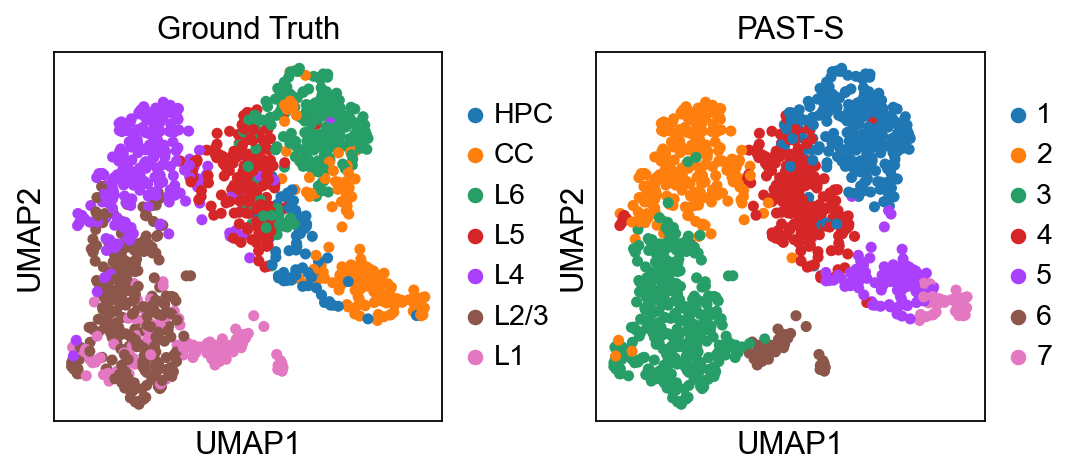

In [12]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-S"])

Visualization of spatial domains colored by annotation and PAST-derived clusters.

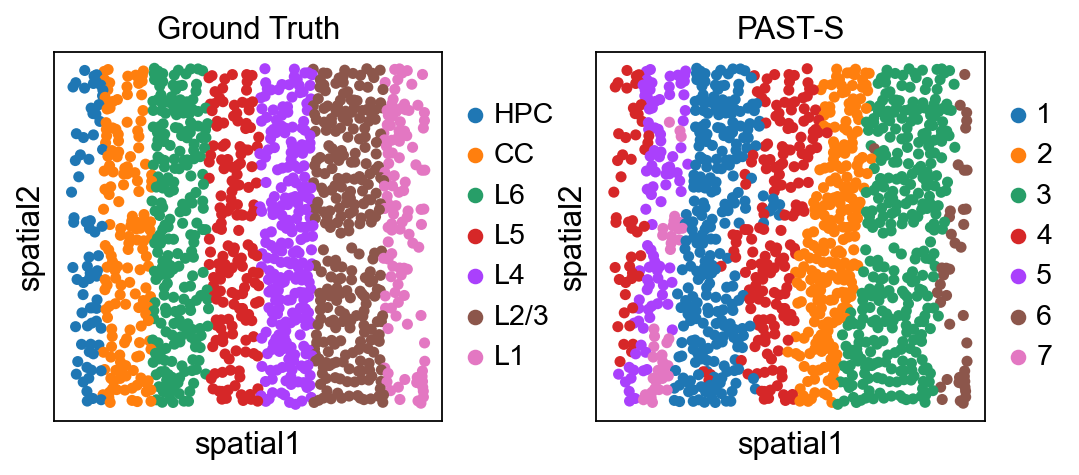

In [13]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-S"])

## Integrating 10x Visium data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [14]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Here we utilize a 10x Visium Mouse Brain Coronal (MBC) dataset as reference data for further external-prior matrix construction. The spatial domain annotation of the refernece data was conducted by squidpy([Palla, et al., 2022](https://www.nature.com/articles/s41592-021-01358-2)) and the gene expression profile combined with annotation could be downloaded from [squidpy package](https://squidpy.readthedocs.io/en/latest/auto_tutorials/tutorial_visium_hne.html). You can also uncomment and execute the following command to download our preprocessed 10X Visium MBC dataset in AnnData format.

In [15]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10x_MBC.h5ad

In [16]:
rdata = sc.read_h5ad(filename="/home/lizhen/code/PAST/Data/10x_MBC.h5ad")
rdata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Same as above, we filter out genes expressed in less than three spots, normalize and logarithmize the count matrix.

In [17]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True)

Initialization of PAST model.

In [18]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we use `rdata` to construct external-prior pseudo-bulk matrix, and users need to specify the `anno_key` stored in `rdata.obs` because the construction of external-prior pseudo-bulk matrix also requires fine annotation of each spot. Here `rdata` is the 10x Visium MBC dataset of AnnData format, and the spatial domain annotation is stored in `rdata.obs["cluster"]`.

In [19]:
PAST_model.model_train(sdata, rdata=rdata, anno_key="cluster", epochs=50, lr=1e-3, batchsize=6400, device=device)

This dataset is small enough to train without Ripplewalk_sampler
add 51 zero features to reference; Current total 1020 genes
bulk_data's shape: (15, 1020)
Epoch:10 Time:0.46s Loss: 10.927826
Epoch:20 Time:0.36s Loss: 5.538720
Epoch:30 Time:0.32s Loss: 4.528119
Epoch:40 Time:0.34s Loss: 3.818743
Epoch:50 Time:0.42s Loss: 3.269795
Epoch:60 Time:0.43s Loss: 2.775825
Epoch:70 Time:0.38s Loss: 2.328354
Epoch:80 Time:0.38s Loss: 1.889099
Epoch:90 Time:0.41s Loss: 1.446759
Epoch:100 Time:0.32s Loss: 1.073192
Epoch:110 Time:0.37s Loss: 0.786154
Epoch:120 Time:0.38s Loss: 0.575389
Epoch:130 Time:0.40s Loss: 0.431945
Epoch:140 Time:0.37s Loss: 0.349049
Epoch:150 Time:0.40s Loss: 0.296874
Epoch:160 Time:0.39s Loss: 0.265066
Epoch:170 Time:0.38s Loss: 0.239506
Epoch:180 Time:0.36s Loss: 0.221549
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [20]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [21]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [22]:
print("MCVA score:", end="\t\t")
print("%.3f"%np.average(past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])))
print("Mclust metrics:", end="\t\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "mclust")
print("Dlouvain metrics:", end="\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "Dlouvain")

MCVA score:		0.754
Mclust metrics:		ARI: 0.562, AMI: 0.624, Homo: 0.605, NMI: 0.627
Dlouvain metrics:	ARI: 0.384, AMI: 0.493, Homo: 0.503, NMI: 0.498


Visualization of latent embeddings colored by annotation and PAST-derived clusters.

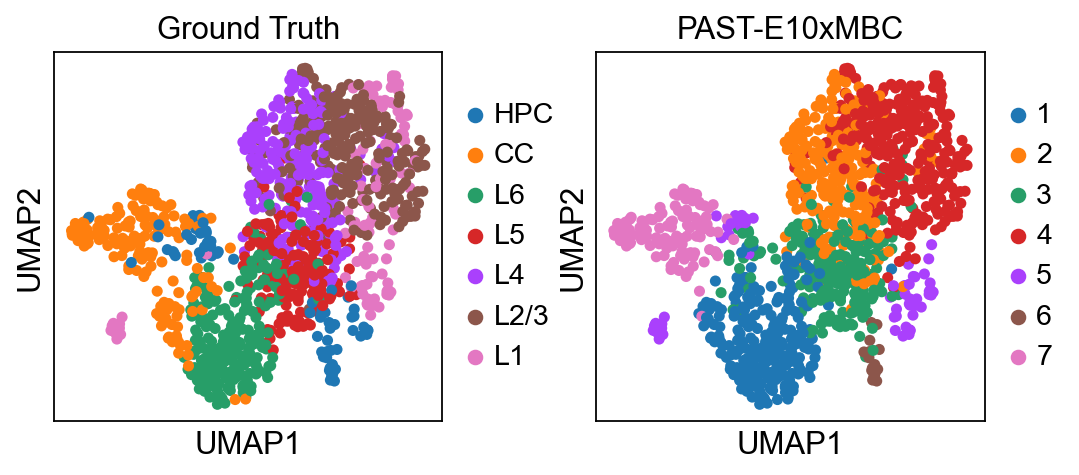

In [23]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-E10xMBC"])

Visualization of spatial domains colored by annotation and PAST-derived clusters.

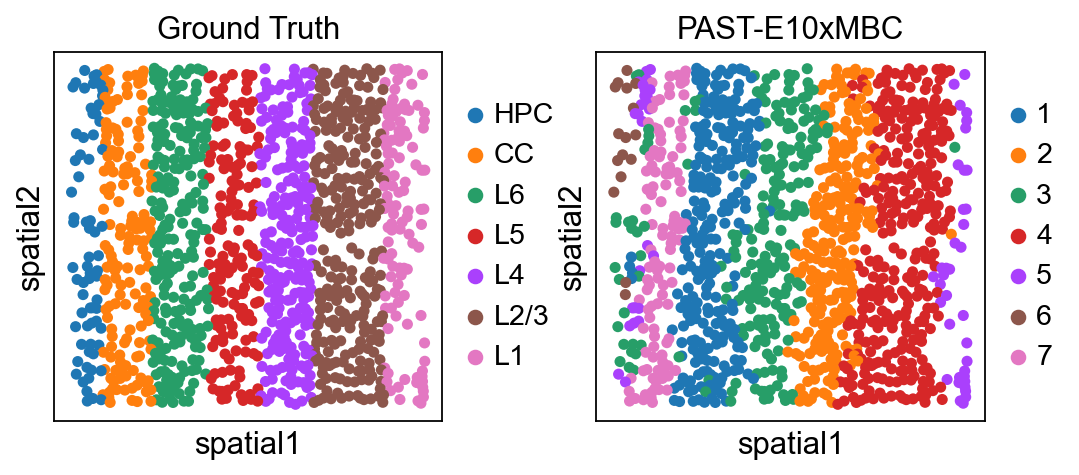

In [24]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-E10xMBC"])

## Integrating scRNA-seq data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [25]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Here we utilize a scRNA-seq Mouse Primary Visual Cortex (MPVC) dataset([Tasic, et al., 2016](https://www.nature.com/articles/nn.4216)) as reference data for further external-prior matrix construction. The spatial domains annotation of the refernece data is stored in `rdata.obs["subclass"]`. You can uncomment and execute the following command to download our preprocessed scRNA-seq MPVC dataset in AnnData format.

In [26]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/scRNAseq_MPVC.h5ad

In [27]:
rdata = sc.read_h5ad(filename="/home/lizhen/code/PAST/Data/scRNAseq_MPVC.h5ad")
rdata

AnnData object with n_obs × n_vars = 14249 × 34617
    obs: 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'subclass'

Same as above, we filter out genes expressed in less than three spots, normalize and logarithmize the count matrix.

In [28]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True)

Initialization of PAST model.

In [29]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we use `rdata` to construct external-prior pseudo-bulk matrix. Here `rdata` is the scRNA-seq MPVC dataset of AnnData format, and the spatial domain annotation is stored in `rdata.obs["subclass"]`.

In [30]:
PAST_model.model_train(sdata, rdata=rdata, anno_key="subclass", epochs=50, lr=1e-3, batchsize=6400, device=device)

This dataset is small enough to train without Ripplewalk_sampler
add 26 zero features to reference; Current total 1020 genes
bulk_data's shape: (23, 1020)
Epoch:10 Time:0.43s Loss: 10.408704
Epoch:20 Time:0.37s Loss: 5.622233
Epoch:30 Time:0.38s Loss: 4.609864
Epoch:40 Time:0.40s Loss: 3.892449
Epoch:50 Time:0.38s Loss: 3.286210
Epoch:60 Time:0.38s Loss: 2.759882
Epoch:70 Time:0.43s Loss: 2.250770
Epoch:80 Time:0.39s Loss: 1.756958
Epoch:90 Time:0.34s Loss: 1.300544
Epoch:100 Time:0.39s Loss: 0.913576
Epoch:110 Time:0.37s Loss: 0.635201
Epoch:120 Time:0.37s Loss: 0.464091
Epoch:130 Time:0.40s Loss: 0.351953
Epoch:140 Time:0.37s Loss: 0.291284
Epoch:150 Time:0.33s Loss: 0.250737
Epoch:160 Time:0.39s Loss: 0.225508
Epoch:170 Time:0.40s Loss: 0.207427
Epoch:180 Time:0.40s Loss: 0.194824
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [31]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [32]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [33]:
print("MCVA score:", end="\t\t")
print("%.3f"%np.average(past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])))
print("Mclust metrics:", end="\t\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "mclust")
print("Dlouvain metrics:", end="\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "layer_label", "Dlouvain")

MCVA score:		0.731
Mclust metrics:		ARI: 0.538, AMI: 0.568, Homo: 0.568, NMI: 0.571
Dlouvain metrics:	ARI: 0.445, AMI: 0.507, Homo: 0.528, NMI: 0.512


Visualization of latent embeddings colored by annotation and PAST-derived clusters.

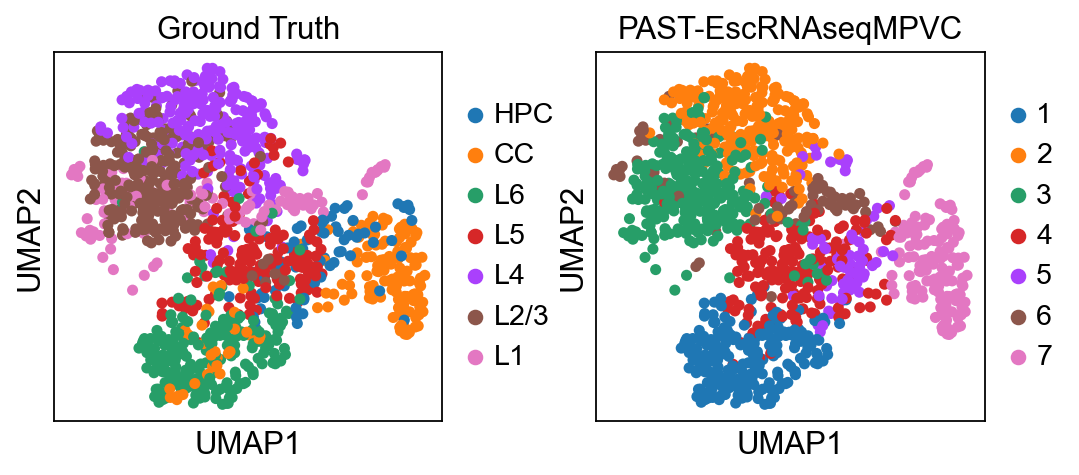

In [34]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-EscRNAseqMPVC"])

Visualization of spatial domains colored by annotation and PAST-derived clusters.

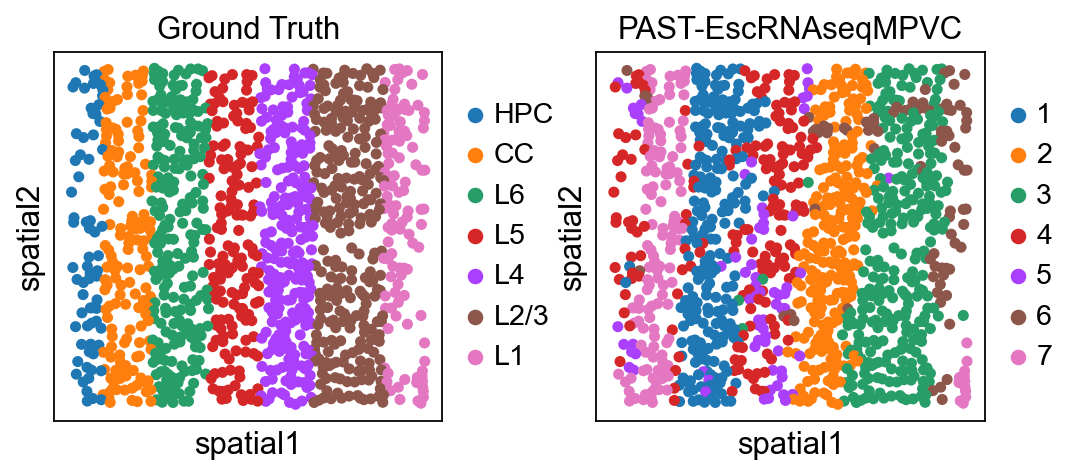

In [35]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-EscRNAseqMPVC"])